In [3]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
import json
import re

In [4]:
punc = re.compile(r"[\n,!\?\’'\+:\"\.\$&@#/\(\)\[\]\|\{\}]")
nonwords = re.compile('^[^a-zA-Z0-9]+$')
links = re.compile(r"https")

In [5]:
def clean_text(df, col_to_clean: str): 
    df[col_to_clean] = df[col_to_clean].str.lower().replace('\n','',regex=True).str.replace('’',"'",regex=True).str.replace(punc,'',regex=True).str.strip()
    df = df[~df[col_to_clean].str.contains(links)]
    df = df[~df[col_to_clean].str.contains(nonwords)]
    df = df[df[col_to_clean]!='']
    return df

def tokinize(df, col_to_tokenize: str):
    df['tokenized'] = df[col_to_tokenize].str.split(' ')
    return df

def get_freqs(df, col_tok='tokenized'):
    df = df.explode(col_tok)
    freqs = df[col_tok].value_counts().to_dict()
    STOPWORDS.update({punc.sub('',x) for x in STOPWORDS})
    new_freqs = {word:freq for (word,freq) in freqs.items() if word not in STOPWORDS}
    return new_freqs

In [6]:
def get_post_df(json_filename):
    df = pd.read_json(json_filename, lines=True)
    # changing the type col
    df = df.rename({"_type": "type"}, axis="columns")
    df = df.replace(to_replace="snscrape.modules.reddit.Submission", value="post")
    df = df.replace(to_replace="snscrape.modules.reddit.Comment", value="comment")
    # change to posts only
    df_posts = df[df["type"] == "post"]
    df_posts = df_posts.dropna(subset=["selftext"])
    df_posts = df_posts.drop(["body"], axis=1)
    df_posts = df_posts.drop(["type", "parentId", "subreddit", "link"], axis=1)
    df_posts = df_posts.reset_index()

    return df, df_posts

def apply_text_len(df, col_text='selftext', minimum_length=500, visualise_lengths=False):
    df['text_len'] = df[col_text].apply(len)
    if(visualise_lengths):
        plt2 = df['text_len'].plot(kind='kde',
            title="Distribution of Comment Length",
            xlabel='Comment Length',
            xlim=0)
    df = df[df["text_len"] >= minimum_length]

    df = clean_text(df, col_text)
    return df

In [7]:
def draw_wordcloud(freqs):
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=freqs)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [8]:
_, doomer_posts = get_post_df("Data/r_doomer_scraped.json")
_, lonely1_posts = get_post_df("Data/r_lonely_scraped.json")
_, lonely2_posts = get_post_df("Data/r_loneliness_scraped.json")
_, depr_posts = get_post_df("Data/r_depression_scraped.json")

In [22]:
doomer_posts = apply_text_len(doomer_posts)
lonely1_posts = apply_text_len(lonely1_posts)
lonely2_posts = apply_text_len(lonely2_posts)
depr_posts = apply_text_len(depr_posts)

In [24]:
print(len(doomer_posts))
print(len(lonely1_posts))
print(len(lonely2_posts))
print(len(depr_posts))

2921
4860
2754
8811


In [16]:
print(f"Average length of doomer: {doomer_posts['text_len'].mean()}")
print(f"Average length of lonely1: {lonely1_posts['text_len'].mean()}")
print(f"Average length of lonely2: {lonely2_posts['text_len'].mean()}")
print(f"Average length of depr: {depr_posts['text_len'].mean()}")

Average length of doomer: 1275.1535145888595
Average length of lonely1: 1228.0242533573862
Average length of lonely2: 1489.4160427807487
Average length of depr: 1336.8282794624015


In [20]:
print("Doomer")
print(f"Earliest post: {doomer_posts['created'].min()}")
print(f"Oldest post: {doomer_posts['created'].max()}")

print("Lonely1")
print(f"Earliest post: {lonely1_posts['created'].min()}")
print(f"Oldest post: {lonely1_posts['created'].max()}")

print("Lonely2")
print(f"Earliest post: {lonely2_posts['created'].min()}")
print(f"Oldest post: {lonely2_posts['created'].max()}")

print("Depr")
print(f"Earliest post: {depr_posts['created'].min()}")
print(f"Oldest post: {depr_posts['created'].max()}")

Doomer
Earliest post: 2019-04-22T10:51:08+00:00
Oldest post: 2022-11-15T16:58:27+00:00
Lonely1
Earliest post: 2022-09-13T03:50:53+00:00
Oldest post: 2022-11-17T00:56:25+00:00
Lonely2
Earliest post: 2011-11-09T07:06:30+00:00
Oldest post: 2022-11-15T03:53:57+00:00
Depr
Earliest post: 2022-02-28T23:44:13+00:00
Oldest post: 2022-11-15T16:33:02+00:00


In [27]:
doomer_users = doomer_posts['author'].unique()
lonely1_users = lonely1_posts['author'].unique()
lonely2_users = lonely2_posts['author'].unique()
depr_users = depr_posts['author'].unique()

print(len(doomer_users))
print(len(lonely1_users))
print(len(lonely2_users))
print(len(depr_users))

1764
3759
2252
8168


In [28]:
doomer_lonely1_users = np.intersect1d(doomer_users, lonely1_users) 
doomer_lonely2_users = np.intersect1d(doomer_users, lonely2_users) 
doomer_depr_users = np.intersect1d(doomer_users, depr_users)

lonely1_lonely2_users = np.intersect1d(lonely1_users, lonely2_users) 
lonely1_depr_users = np.intersect1d(lonely1_users, depr_users) 
lonely2_depr_users = np.intersect1d(lonely2_users, depr_users) 

common_users1 = np.intersect1d(doomer_lonely1_users, doomer_depr_users)
common_users2 = np.intersect1d(doomer_lonely2_users, doomer_depr_users)
common_users = np.intersect1d(common_users1, common_users2)

In [30]:
print(len(doomer_lonely1_users))
print(len(doomer_lonely2_users))
print(len(doomer_depr_users))

print(len(lonely1_lonely2_users))
print(len(lonely1_depr_users))
print(len(lonely2_depr_users))

print(len(common_users1))
print(len(common_users2))
print(len(common_users))

13
6
14
31
161
25
2
1
0


In [10]:
doomer_posts = tokinize(doomer_posts, 'selftext')
lonely1_posts = tokinize(lonely1_posts, 'selftext')
lonely2_posts = tokinize(lonely2_posts, 'selftext')
depr_posts = tokinize(depr_posts, 'selftext')

In [11]:
doomer_freqs = get_freqs(doomer_posts)

In [12]:
lonely1_freqs = get_freqs(lonely1_posts)
lonely2_freqs = get_freqs(lonely2_posts)

In [13]:
depr_freqs = get_freqs(depr_posts)

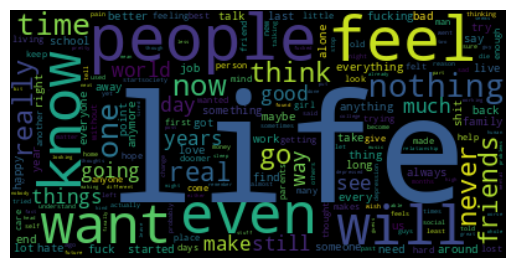

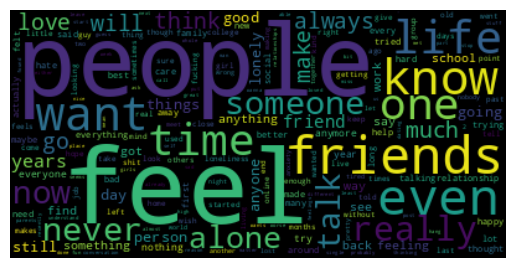

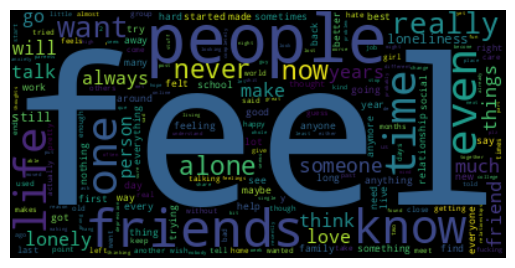

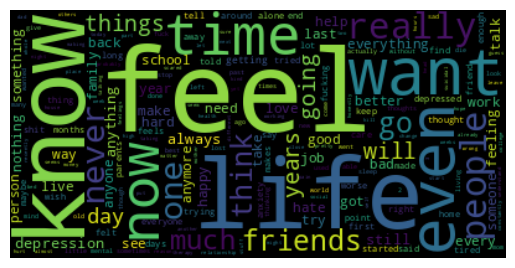

In [14]:
draw_wordcloud(doomer_freqs)
draw_wordcloud(lonely1_freqs)
draw_wordcloud(lonely2_freqs)
draw_wordcloud(depr_freqs)

In [38]:
doomer_posts.sample(n = 50)['selftext'].to_csv('Data/sample50_doomer.txt', sep=' ')
lonely1_posts.sample(n = 50)['selftext'].to_csv('Data/sample50_lonely.txt', sep=' ')
lonely2_posts.sample(n = 50)['selftext'].to_csv('Data/sample50_loneliness.txt', sep=' ')
depr_posts.sample(n = 50)['selftext'].to_csv('Data/sample50_depr.txt', sep=' ')

In [23]:
cloud = WordCloud(stopwords=STOPWORDS,height=1000,width=2000).generate_from_text(''.join(doomer_posts['selftext']))

In [ ]:
newfreqs.pop("")

In [ ]:
punc = re.compile(r"[\n,!\?\’'\+:\"\.\$&@#/\(\)\[\]\|\{\}]")
plt.figure(figsize=(8,5),dpi=200)
plt.axis('off')
plt.imshow(cloud,interpolation='bilinear')

In [ ]:
plt.figure(figsize=(7,5),dpi=400)
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

In [ ]:
df['body_length'] = df['body'].apply(len)

In [ ]:
plt2 = doomer_df['text_len'].plot(kind='kde',
    title="Distribution of Comment Length",
    xlabel='Comment Length',
    xlim=0)

In [ ]:
df[df['body_length']>500]['body']

In [ ]:
df['tokenized'] = df['body'].astype(str).str.lower().str.split(" ")
df = df.explode('tokenized')
freqs = df['tokenized'].value_counts().to_dict()
newfreqs = {k:v for k,v in freqs.items() if k not in STOPWORDS}


df = clean_text(df)

In [10]:
doomer_comments.assign(text_len=doomer_comments['body'].astype(str).map(len))
doomer_posts.assign(text_len=doomer_posts['selftext'].astype(str).map(len))

doomer_df = pd.concat([doomer_posts, doomer_comments])

In [ ]:
doomer_df['te']

In [11]:
ave_txt_len = int(doomer_df[['text_len']].mean(axis=0))
shortest_txt_len = int(min(doomer_df['text_len']))
longest_txt_len = int(max(doomer_df['text_len']))

KeyError: "None of [Index(['text_len'], dtype='object')] are in the [columns]"

In [ ]:
plt2 = doomer_df['text_len'].plot(kind='kde',
    title="Distribution of Comment Length",
    xlabel='Comment Length',
    xlim=0)

In [14]:
lonely2_comments = doomer_comments[doomer_comments['body'].str.contains('lonely')]


In [15]:
lonely2_posts = doomer_posts[doomer_posts['selftext'].astype(str).str.contains('lonely')]

In [17]:
lonely2_posts.reset_index(drop=True,inplace=True)

In [22]:
import re

In [41]:
import nltk

In [ ]:
nltk.

In [24]:
lonely = re.compile(".{40}lonely.{40}")

In [29]:
from collections import Counter

In [36]:
df = pd.Series(Counter(text.split()))

In [40]:
df.nlargest(25)

and        73
I          49
to         49
her        44
a          35
she        28
was        27
the        26
in         21
that       14
being      14
with       14
for        14
time       13
it         12
me         12
be         11
of         11
had        11
She        11
at         11
is         10
talking    10
this        9
all         9
dtype: int64

In [34]:
Counter(text.split())

Counter({'To': 1,
         'explain': 1,
         'my': 4,
         'story': 2,
         'I': 49,
         'will': 1,
         'start': 1,
         'from': 2,
         'the': 26,
         'beginning.': 1,
         'met': 4,
         'a': 35,
         'girl': 4,
         'online': 4,
         'and': 73,
         'we': 7,
         'really': 7,
         'hit': 4,
         'it': 12,
         'off.': 1,
         'know': 6,
         'meeting': 2,
         'girls': 1,
         'is': 10,
         'considered': 1,
         'cringy': 1,
         'pathetic': 1,
         'but': 3,
         'have': 6,
         'mental': 1,
         'impairment.': 1,
         'Aspergers': 1,
         'disorder': 2,
         'which': 2,
         'basically': 3,
         'condition': 1,
         'that': 14,
         'makes': 1,
         'you': 2,
         'hard': 3,
         'time': 13,
         'socialising': 1,
         'being': 14,
         'comfortable': 1,
         'around': 2,
         'others.': 1,
         'So

In [28]:
text.split()

['To',
 'explain',
 'my',
 'story',
 'I',
 'will',
 'start',
 'from',
 'the',
 'beginning.',
 'I',
 'met',
 'a',
 'girl',
 'online',
 'and',
 'we',
 'really',
 'hit',
 'it',
 'off.',
 'I',
 'know',
 'meeting',
 'girls',
 'online',
 'is',
 'considered',
 'cringy',
 'and',
 'pathetic',
 'but',
 'I',
 'have',
 'a',
 'mental',
 'impairment.',
 'I',
 'have',
 'Aspergers',
 'disorder',
 'which',
 'is',
 'basically',
 'a',
 'condition',
 'that',
 'makes',
 'you',
 'have',
 'a',
 'really',
 'hard',
 'time',
 'socialising',
 'and',
 'being',
 'comfortable',
 'around',
 'others.',
 'So',
 'to',
 'finally',
 'be',
 'able',
 'to',
 'hit',
 'it',
 'of',
 'with',
 'a',
 'girl',
 'that',
 'looked',
 'very',
 'attractive',
 'to',
 'me',
 'and',
 'easy',
 'to',
 'talk',
 'to',
 'felt',
 'really',
 'nice.',
 'We',
 'hit',
 'things',
 'off',
 'so',
 'well',
 'that',
 'we',
 'decide',
 'to',
 'be',
 'in',
 'a',
 'online',
 'relationship',
 'together',
 'and',
 'decided',
 'we',
 'where',
 'in',
 'love',
 

In [26]:
lonely.findall(text)

[' many hours being there when they where lonely and had nobody and locked in some shi*t']

In [25]:
text = lonely2_posts.head()['selftext'][0]